In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import inspect
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Get to know the measurement columns..
columns = inspector.get_columns('measurement')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [9]:
## Get to know the station columns..
columns = inspector.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Climate Analysis

In [10]:
# Calculate the date 1 year ago from the last data point in the database
# Obtain date range which shows the starting point date..
earliestdt = session.query(Measurement.date).order_by(Measurement.date).first()
latestdt = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {earliestdt[0]} , Latest: {latestdt[0]}")

Earliest: 2010-01-01 , Latest: 2017-08-23


<Figure size 720x504 with 0 Axes>

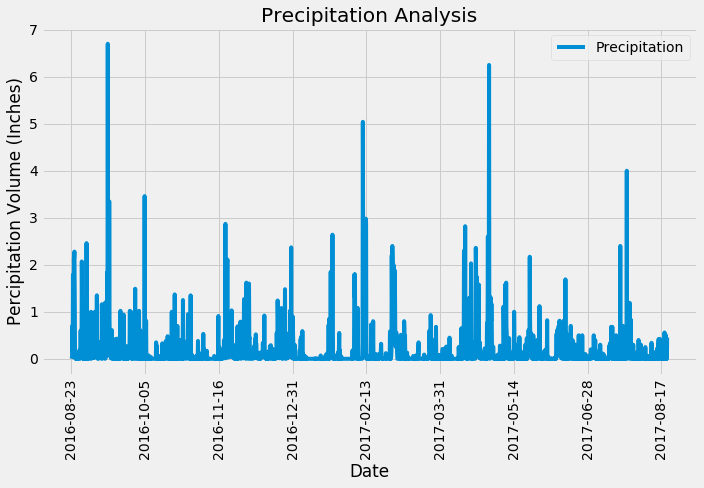

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

latestdate = dt.datetime.strptime(latestdt[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
querydata = session.query(*sel).filter(Measurement.date >= querydate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip = pd.DataFrame(querydata, columns=['Date','Precipitation'])
precip = precip.dropna(how='any')  
precip = precip.sort_values(["Date"], ascending=True)
precip = precip.set_index("Date")

fig1 = plt.figure(figsize=(10,7))
precip = pd.DataFrame(querydata, columns=['Date','Precipitation'])
precip = precip.dropna(how='any')  
precip = precip.sort_values(["Date"], ascending=True)
precip.plot('Date', 'Precipitation', figsize=(10,7))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Percipitation Volume (Inches)")
plt.title("Precipitation Analysis")
plt.xticks(rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()
plt.close(fig1)

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [43]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [Measurement.station,func.count(Measurement.id)]
mostactivestations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
mostactivestations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#set the most active station

#query for most active station 
stationID = mostactivestations[0][0]
stationName = (session.query(Station.name).filter_by(station = stationID))
stationName = stationName[0][0]
print(f"The most active station is {stationID}: {stationName}.")

#query for highest temperature
maxTemp = (session.query(Measurement.tobs).filter(Measurement.station == stationID).order_by(Measurement.tobs.desc()).first())
maxTemp = maxTemp[0]
print(f"The highest temperature recorded there is {maxTemp} degrees Farenheit.")

#query for lowest temperature
minTemp = (session.query(Measurement.tobs).filter(Measurement.station == stationID).order_by(Measurement.tobs.asc()).first())
minTemp = minTemp[0]
print(f"The lowest temperature recorded there is {minTemp} degrees Farenheit.")

#query for average temperature
avgTemp = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The average temperature recorded there is {avgTemp} degrees Farenheit.")


The most active station is USC00519281: WAIHEE 837.5, HI US.
The highest temperature recorded there is 85.0 degrees Farenheit.
The lowest temperature recorded there is 54.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


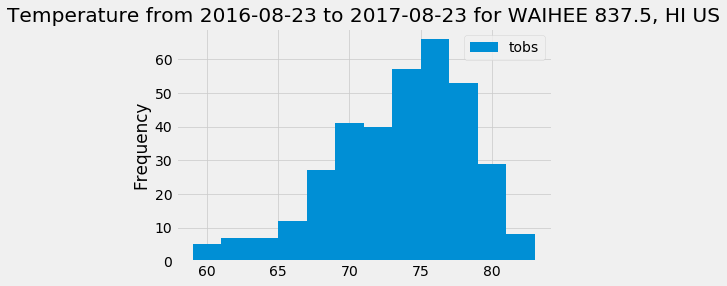

In [49]:
# Choose the station with the highest number of temperature observations.
q = session.query(Measurement.tobs).filter(Measurement.station == mostactivestations[0][0]).filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(q))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
q = session.query(*sel).all()
stations_desc = pd.DataFrame(q, columns=['Station','Name','Latitude','Longitude','Elevation'])
stationname = stations_desc.loc[stations_desc["Station"] == mostactivestations[0][0],"Name"].tolist()[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temperatures, bins=12, rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {querydate} to {latestdt[0]} for {stationname}")
plt.legend()

## Bonus Challenge Assignment

In [51]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d      
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [60]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = '2017-05-28'
enddate = '2017-06-05'
result = calc_temps(startdate,enddate)[0]
result

(71.0, 77.28301886792453, 82.0)

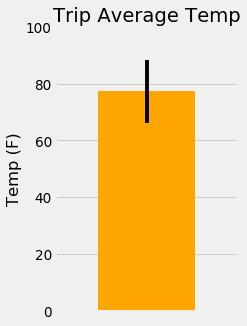

In [61]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = [0]
y_pos = [result[1]]
error = [(result[2] - result[0])]

wdth = 3
hght = 5
dpth = 70

plt.figure(figsize=(wdth, hght), dpi=dpth)
plt.bar(x_pos,y_pos,color='orange', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Average Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

In [62]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

startdate = '2017-05-28'
enddate = '2017-06-05'

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
stations = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','Precip Amt'])
stations = stations.dropna(how='any')  
stations

,Station,Name,Latitude,Longitude,Elevation,Precip Amt
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.20
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.09
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.84
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.44
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.32
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.26


In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.    
    Args:
        date (str): A date string in the format '%m-%d'        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [63]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startdate = '2017-05-28'
enddate = '2017-06-05'

# Use the start and end date to create a range of dates
strdtobj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(enddate, '%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
tripdates = []
normals =[]
while (strdtobj <= enddtobj):
    tripdates.append(dt.datetime.strftime(strdtobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(strdtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    strdtobj = strdtobj + dt.timedelta(days = 1)

normals

[[67.0, 74.27777777777777, 82.0],
 [64.0, 74.19607843137256, 80.0],
 [69.0, 74.33333333333333, 81.0],
 [68.0, 74.4, 81.0],
 [64.0, 74.6140350877193, 81.0],
 [65.0, 74.4, 81.0],
 [65.0, 74.03448275862068, 80.0],
 [65.0, 73.81818181818181, 81.0],
 [68.0, 74.85454545454546, 81.0]]

In [66]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
thistrip = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
thistrip['Date'] = tripdates
thistrip = thistrip.set_index("Date")
thistrip

,tmin,tavg,tmax
Date,,,
2017-05-28,67.0,74.277778,82.0
2017-05-29,64.0,74.196078,80.0
2017-05-30,69.0,74.333333,81.0
2017-05-31,68.0,74.400000,81.0
2017-06-01,64.0,74.614035,81.0
2017-06-02,65.0,74.400000,81.0
2017-06-03,65.0,74.034483,80.0
2017-06-04,65.0,73.818182,81.0
2017-06-05,68.0,74.854545,81.0


(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 <a list of 7 Text xticklabel objects>)

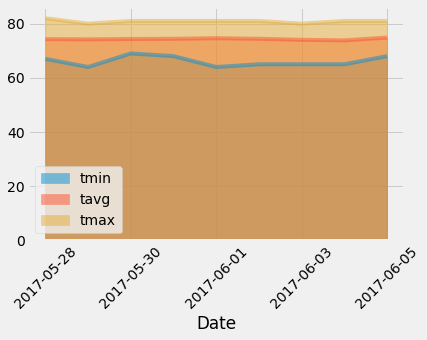

In [67]:
# Plot the daily normals as an area plot with `stacked=False`
thistrip.plot.area(stacked=False)
plt.xticks(rotation=45)